# import required libs 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys

import torch as T
import torchvision as TV
from torchvision.utils import make_grid
import torchvision.transforms as transform
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from glob import glob 


# load the dataset

In [2]:
train_path = glob('./cityscapes_data/train/*')
valid_path = glob('./cityscapes_data/val/*')
print(f"Train: {len(train_path)} images, Val: {len(valid_path)} images")

Train: 2975 images, Val: 500 images


# image visulization

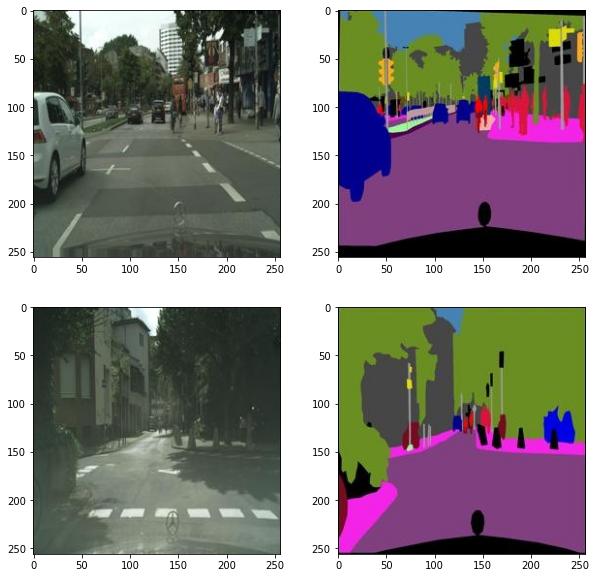

In [3]:
k = 2 # change k to view more pictures
fig, ax = plt.subplots(k,2, figsize=(10,5*k))
for i in range(k):
    img = plt.imread(train_path[i])
    ax[i][0].imshow(img[:, :256])
    ax[i][1].imshow(img[:, 256:])

# prepare customized dataset

In [4]:
# in pytorch,  all dataset must be a subclass of torch Dataset class, like below:
class CityDataset(Dataset):
    # every dataset must overwrite these three methods: __init__, __len__, __getitem__
    def __init__(self, image_path, transform_img, transform_label):
        super().__init__() # init the father class (optional)
        self.image_path = image_path
        self.transform_img = transform_img
        self.transform_label = transform_label
        
    def __len__(self):
        return len(self.image_path)
    
    def __getitem__(self, idx):
        img = plt.imread(self.image_path[idx])
        image, label = img[:, :int(img.shape[1]/2)], img[:, int(img.shape[1]/2):]
        
        if self.transform_img:
            # if using transform to change the shape of the image
            image = self.transform_img(image)
            
        if self.transform_label:
            # if using transform to change the shape of labels
            label = self.transform_label(label)
            
        return image, label        

In [5]:
# define the transform methods to be passed to above dataset
myTransformImage = transform.Compose(
    [
        transform.ToTensor(), # needed for almost every CV tasks because the images are stored as np.array at first, we need them to be torch.Tensor
        transform.RandomHorizontalFlip(p=0.9)
    ]
)

myTransformLabel = transform.Compose(
    [
        transform.ToTensor()
    ]
)

In [6]:
train_data = CityDataset(train_path, myTransformImage, myTransformLabel)
valid_data = CityDataset(valid_path, myTransformImage, myTransformLabel)

In [7]:
batch_size = 16
train_loader = DataLoader(train_data, batch_size)
valid_loader = DataLoader(valid_data, batch_size)

In [17]:
# helper functions for print images
def show(img, output, label, denorm=False):
    # move all tensors to cpu in case they are on gpu
    img, output, label = img.cpu(), output.cpu(), label.cpu()
    fig, ax = plt.subplots(len(output), 3, figsize=(10,2.5*len(output)))
    for i in range(len(output)):
        if (len(output)==batch_size-1):
            Img, Lab, act = img[i], output[i], label[i]
            Img, Lab, act = Img, Lab.detach().permute(1,2,0).numpy(), act
            ax[i][0].imshow(Img.permute(1,2,0))
            ax[i][1].imshow(Lab)
            ax[i][2].imshow(act.permute(1,2,0))
        else:
            Img, Lab, act = img[i], output[i], label[i]
            Img, Lab, act = Img, Lab.detach().permute(1,2,0).numpy(), act
            ax[0].imshow(Img.permute(1,2,0))
            ax[1].imshow(Lab)
            ax[2].imshow(act.permute(1,2,0))
    plt.show()

In [9]:
device = T.device("cuda:0") if T.cuda.is_available() else 'cpu'

# build UNet as model


In [10]:
# all models in pytorch must be inherited from nn.Module so it can do all the
# dirty works for you.
class Convblock(nn.Module):
    def __init__(self, input_channel, output_channel, kernal=3, stride=1, padding=1):
        super().__init__()
        self.convblock = nn.Sequential(
            nn.Conv2d(input_channel, output_channel, kernal, stride, padding),
            nn.BatchNorm2d(output_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(output_channel, output_channel, kernal),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        x = self.convblock(x)
        return x


In [11]:
class UNet(nn.Module):
    def __init__(self, input_channel, retain=True):
        super().__init__()
        self.conv1 = Convblock(input_channel, 32)
        self.conv2 = Convblock(32, 64)
        self.conv3 = Convblock(64, 128)
        self.conv4 = Convblock(128, 256)
        self.neck = nn.Conv2d(256, 512, 3, 1)
        self.upconv4 = nn.ConvTranspose2d(512, 256, 3, 2, 0, 1)
        self.dconv4 = Convblock(512, 256)
        self.upconv3 = nn.ConvTranspose2d(256, 128, 3, 2, 0, 1)
        self.dconv3 = Convblock(256, 128)
        self.upconv2 = nn.ConvTranspose2d(128, 64, 3, 2, 0, 1)
        self.dconv2 = Convblock(128, 64)
        self.upconv1 = nn.ConvTranspose2d(64, 32, 3, 2, 0, 1)
        self.dconv1 = Convblock(64, 32)
        self.out = nn.Conv2d(32, 3, 1, 1)
        self.retain = retain 
        
    def forward(self, x):
        # left part, encoder:
        conv1 = self.conv1(x)
        pool1 = F.max_pool2d(conv1, kernel_size=2, stride=2)
        conv2 = self.conv2(pool1)
        pool2 = F.max_pool2d(conv2, kernel_size=2, stride=2)
        conv3 = self.conv3(pool2)
        pool3 = F.max_pool2d(conv3, kernel_size=2, stride=2)
        conv4 = self.conv4(pool3)
        pool4 = F.max_pool2d(conv4, kernel_size=2, stride=2)
        
        neck = self.neck(pool4)
        
        # right part, decoder
        upconv4 = self.upconv4(neck)
        croped = self.crop(conv4, upconv4)
        # skip connection
        dconv4 = self.dconv4(T.cat([upconv4, croped], 1))
        
        upconv3 = self.upconv3(dconv4)
        croped = self.crop(conv3, upconv3)
        # skip connection
        dconv3 = self.dconv3(T.cat([upconv3, croped], 1))
        
        upconv2 = self.upconv2(dconv3)
        croped = self.crop(conv2, upconv2)
        # skip connection
        dconv2 = self.dconv2(T.cat([upconv2, croped], 1))
        
        upconv1 = self.upconv1(dconv2)
        croped = self.crop(conv1, upconv1)
        # skip connection
        dconv1 = self.dconv1(T.cat([upconv1, croped], 1))
        
        out = self.out(dconv1)
        
        if self.retain == True:
            out = F.interpolate(out, list(x.shape)[2:])
        return out
    
    
    def crop(self, input_tensor, target_tensor):
        # crop the decoder tensor into the same shape as encoder tensor
        _, _, H, W = target_tensor.shape
        return transform.CenterCrop([H, W])(input_tensor)

# setting up experiment configurations

In [12]:
model = UNet(3).float().to(device)

In [13]:
lr = 0.01
epoch = 30

In [14]:
loss_fn = nn.MSELoss()
optimizer = T.optim.AdamW(model.parameters(), lr=lr)

In [15]:
train_acc = []
valid_acc = []
train_loss = []
valid_loss = []

# actually train the model and run validation when an epoch ends

100%|██████████| 186/186 [00:21<00:00,  8.67it/s]


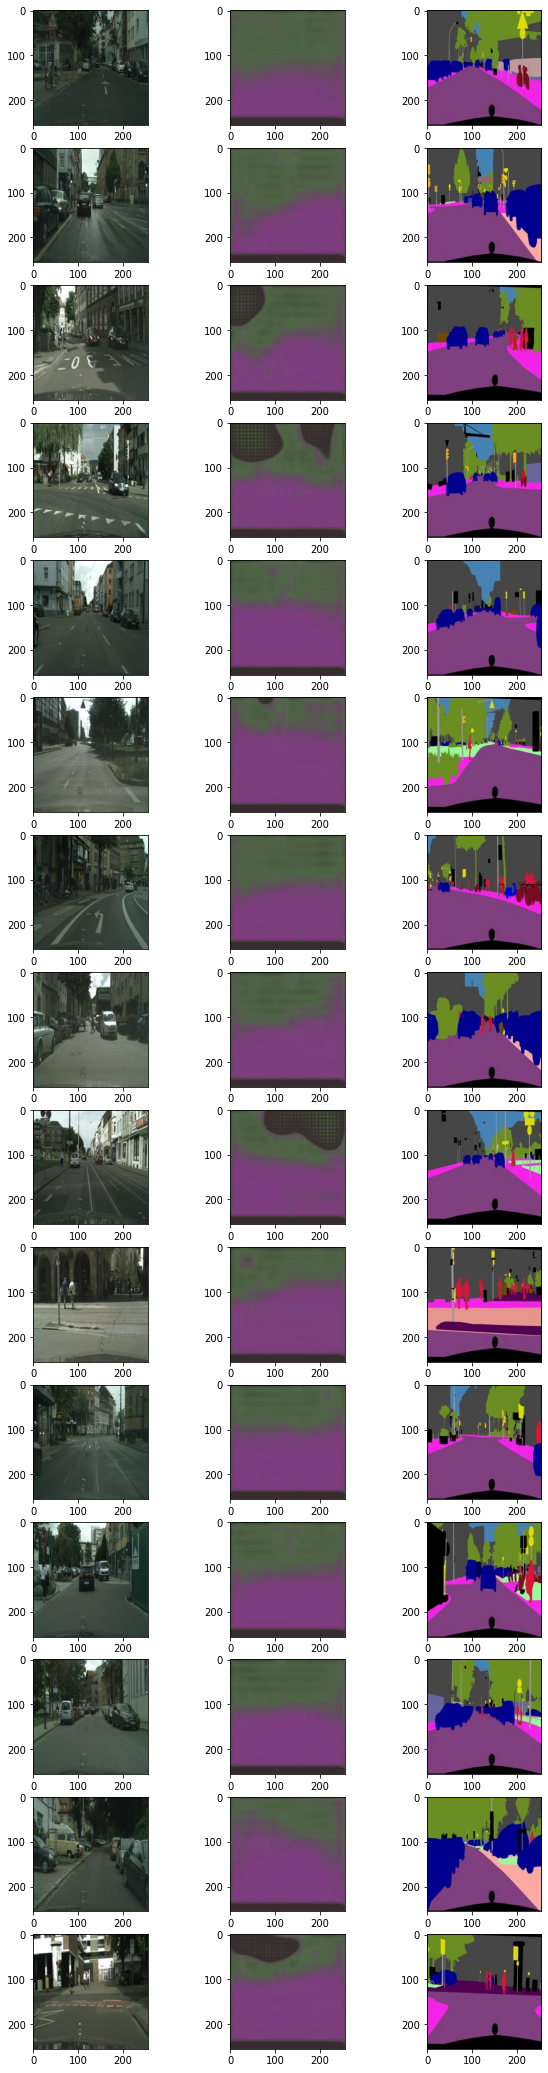

100%|██████████| 32/32 [00:01<00:00, 16.01it/s]


epoch: 0, train_loss: 0.0361118688979136 , valid loss: 0.03441719006514177


100%|██████████| 32/32 [00:01<00:00, 16.19it/s]


epoch: 1, train_loss: 0.033357305792711116 , valid loss: 0.03047909081215039


100%|██████████| 32/32 [00:01<00:00, 16.91it/s]


epoch: 2, train_loss: 0.031190074589704315 , valid loss: 0.028902745398227125


100%|██████████| 32/32 [00:01<00:00, 16.19it/s]


epoch: 3, train_loss: 0.029639270647318774 , valid loss: 0.02771434764144942


100%|██████████| 32/32 [00:01<00:00, 16.01it/s]


epoch: 4, train_loss: 0.02881403190274072 , valid loss: 0.027048356656450778


100%|██████████| 186/186 [00:22<00:00,  8.36it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1

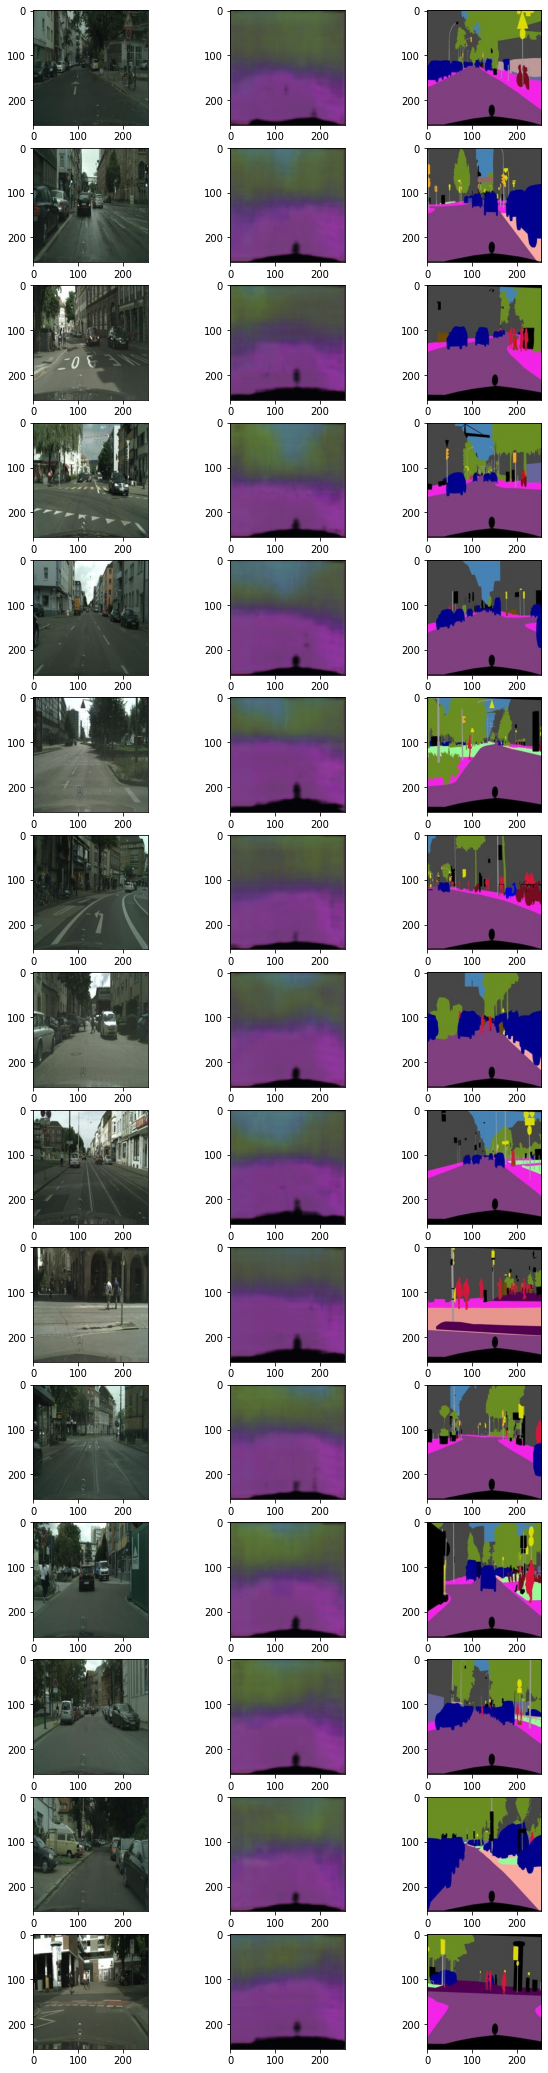

100%|██████████| 32/32 [00:02<00:00, 15.90it/s]


epoch: 5, train_loss: 0.02815568015500102 , valid loss: 0.026606845611240715


100%|██████████| 32/32 [00:01<00:00, 16.08it/s]


epoch: 6, train_loss: 0.02767296505951753 , valid loss: 0.02622207044623792


100%|██████████| 32/32 [00:01<00:00, 16.20it/s]


epoch: 7, train_loss: 0.02741323257245684 , valid loss: 0.02623300440609455


100%|██████████| 32/32 [00:02<00:00, 15.77it/s]


epoch: 8, train_loss: 0.02721234569225901 , valid loss: 0.026227136491797864


100%|██████████| 32/32 [00:01<00:00, 17.06it/s]


epoch: 9, train_loss: 0.02702177319956082 , valid loss: 0.026049172563944012


100%|██████████| 186/186 [00:21<00:00,  8.46it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


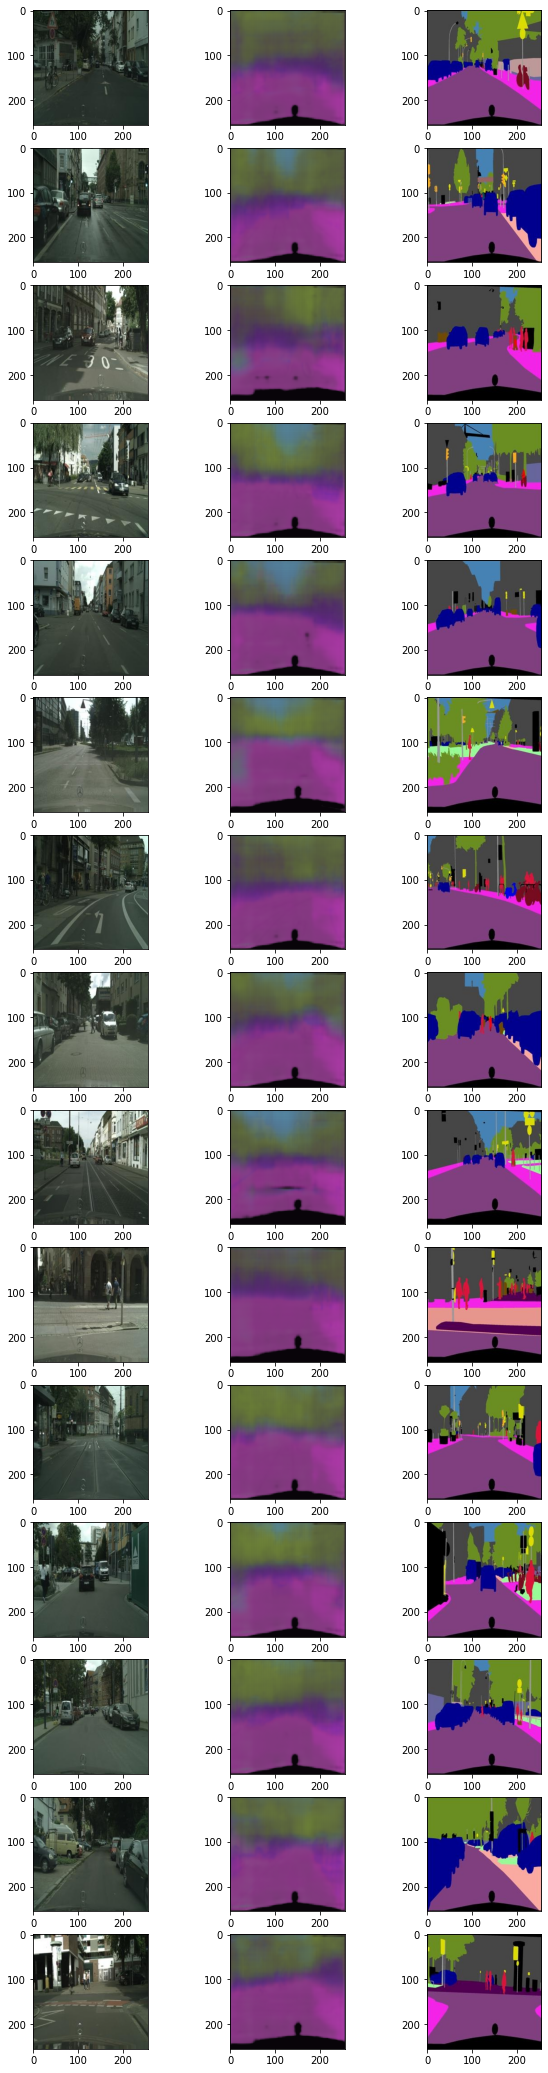

100%|██████████| 32/32 [00:01<00:00, 16.74it/s]


epoch: 10, train_loss: 0.02686697611164662 , valid loss: 0.025846149073913693


100%|██████████| 32/32 [00:01<00:00, 16.94it/s]


epoch: 11, train_loss: 0.026513589946653253 , valid loss: 0.025104676256887615


100%|██████████| 32/32 [00:01<00:00, 16.80it/s]


epoch: 12, train_loss: 0.026111437588609676 , valid loss: 0.02493405557470396


100%|██████████| 32/32 [00:01<00:00, 16.42it/s]


epoch: 13, train_loss: 0.025716479797597214 , valid loss: 0.02490146510535851


100%|██████████| 32/32 [00:01<00:00, 16.73it/s]


epoch: 14, train_loss: 0.025271632037656283 , valid loss: 0.02458994189510122


100%|██████████| 186/186 [00:21<00:00,  8.56it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1

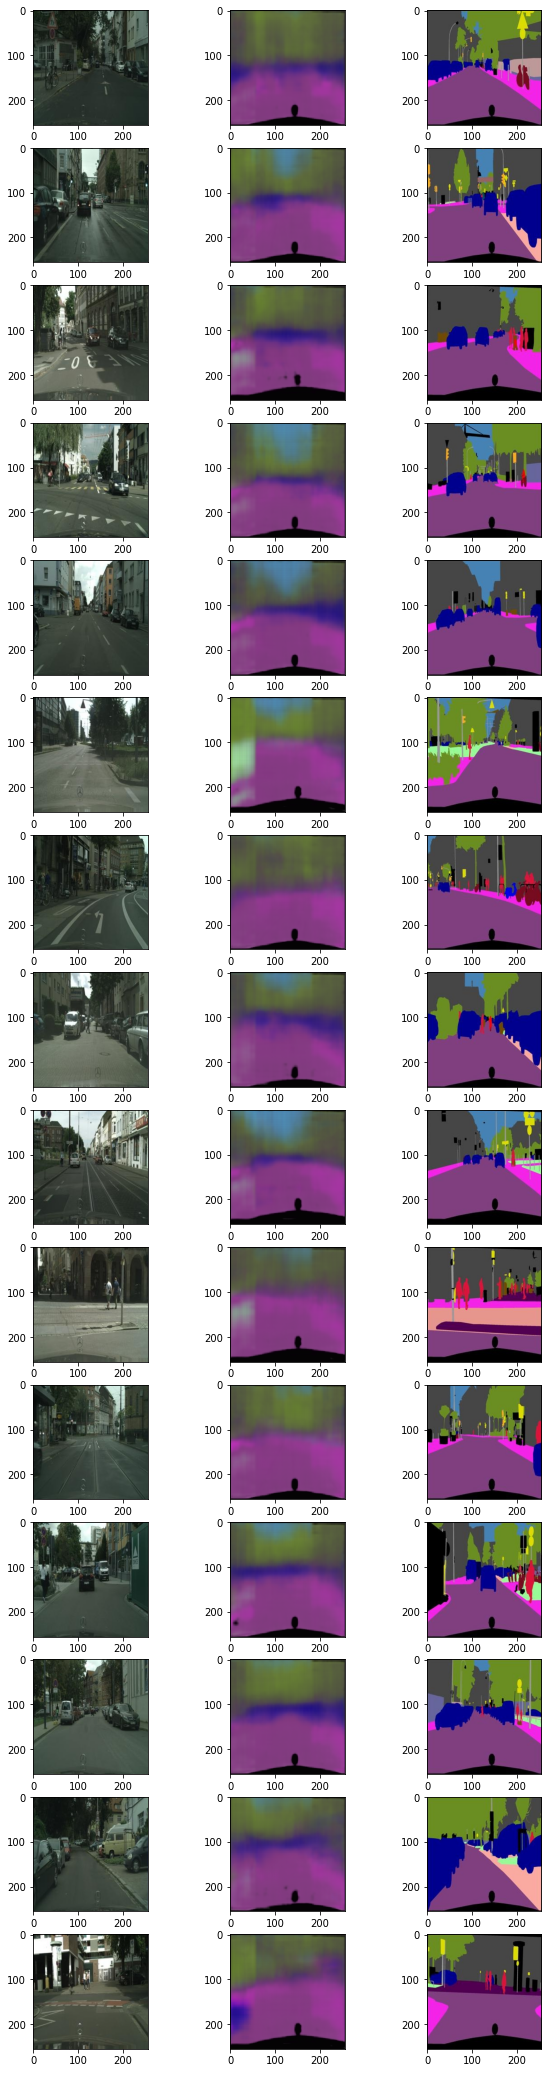

100%|██████████| 32/32 [00:02<00:00, 15.16it/s]


epoch: 15, train_loss: 0.024684169790357032 , valid loss: 0.024764291185420007


100%|██████████| 32/32 [00:02<00:00, 14.38it/s]


epoch: 16, train_loss: 0.02430038155126636 , valid loss: 0.024265778076369315


100%|██████████| 32/32 [00:02<00:00, 15.40it/s]


epoch: 17, train_loss: 0.02401459060849682 , valid loss: 0.023796618857886642


100%|██████████| 32/32 [00:01<00:00, 16.17it/s]


epoch: 18, train_loss: 0.023852291246575695 , valid loss: 0.024245075474027544


100%|██████████| 32/32 [00:01<00:00, 16.73it/s]


epoch: 19, train_loss: 0.023604378454707642 , valid loss: 0.023543968272861093


100%|██████████| 186/186 [00:21<00:00,  8.61it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1

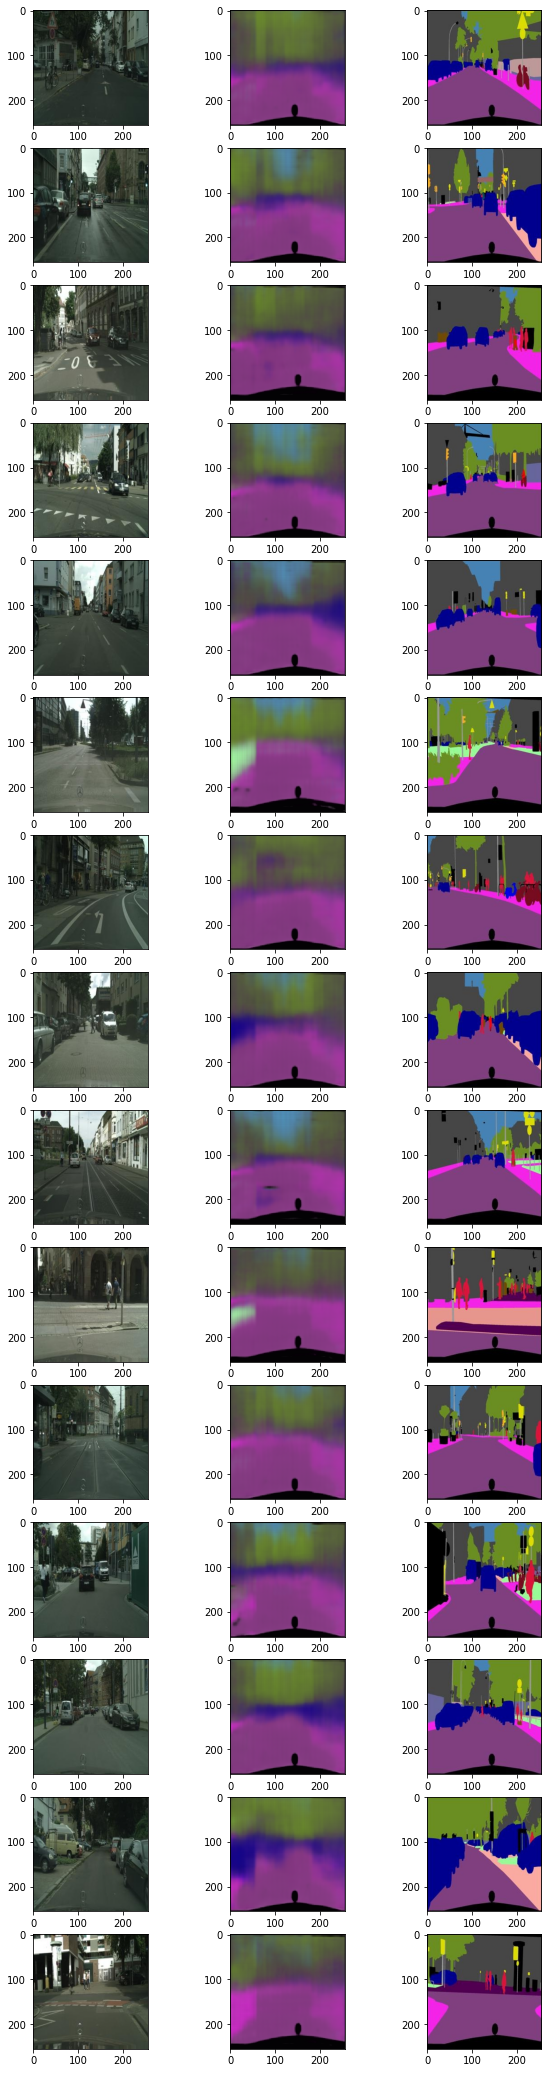

100%|██████████| 32/32 [00:01<00:00, 16.88it/s]


epoch: 20, train_loss: 0.02347044518557928 , valid loss: 0.02338264463469386


100%|██████████| 32/32 [00:02<00:00, 15.59it/s]


epoch: 21, train_loss: 0.023301893374532142 , valid loss: 0.02377823943970725


 42%|████▏     | 78/186 [00:08<00:12,  8.77it/s]

In [ ]:
from tqdm import tqdm
for i in range(epoch):
    train_loss_epoch = 0
    valid_loss_epoch = 0
    
    # training loop in a epoch
    for img, label in tqdm(train_loader):
        optimizer.zero_grad()
        img = img.to(device)
        label = label.to(device)
        pred_label = model(img)
        loss = loss_fn(pred_label, label)
        loss.backward()
        optimizer.step()
        train_loss_epoch += loss.item()
        
    if i % 5 == 0:
        show(img, pred_label, label)
        
    train_loss.append(train_loss_epoch/len(train_loader))
    
    # test loop in a epoch
    for img, label in tqdm(valid_loader):
        with T.no_grad():
            img = img.to(device)
            label = label.to(device)
            pred_label = model(img)
            loss = loss_fn(pred_label, label)
            valid_loss_epoch += loss.item()

    valid_loss.append(valid_loss_epoch/len(valid_loader))
    
    print(f"epoch: {i}, train_loss: {train_loss[-1]} , valid loss: {valid_loss[-1]}")

# plot the train and valid loss w.r.t training epoch

In [24]:
type(train_loss[0])

float

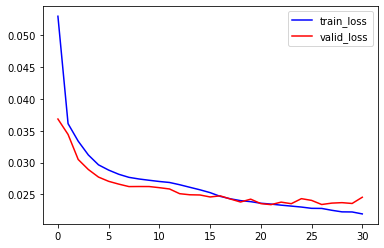

In [25]:
plt.plot(train_loss, color='b', label='train_loss')
plt.plot(valid_loss, color='r', label='valid_loss')
plt.legend()

# save the model to the local folder

In [27]:
T.save(model.state_dict(), f"./saved_models/UNet_e{epoch}.pt")